## Importing Libraries

In [673]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from collections import  Counter, defaultdict
import json
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop=set(stopwords.words('english'))
import re
from wordcloud import WordCloud
import emoji
from spellchecker import SpellChecker
from textblob import TextBlob
from mlxtend.plotting import plot_confusion_matrix
from nltk.stem import PorterStemmer 
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import string

In [674]:
#reading the data
tweet_train= pd.read_csv('train.csv')
tweet_test=pd.read_csv('test.csv')
tweet_train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [675]:
print(tweet_train.shape)
print(tweet_test.shape)

(7613, 5)
(3263, 4)


Target Class Distribution
0    0.57034
1    0.42966
Name: target, dtype: float64


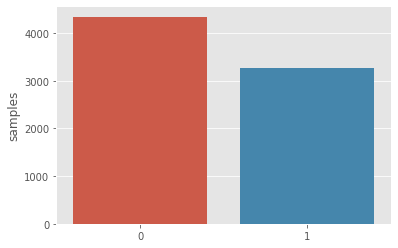

In [676]:
print("Target Class Distribution")
print(tweet_train['target'].value_counts(normalize=True))
sns.barplot(tweet_train['target'].value_counts().index, tweet_train['target'].value_counts()).set_ylabel('samples')
plt.show()

In [677]:
#checking consistency of datatype in train and test
tweet_train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [678]:
tweet_test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [679]:
# number of nulls 
tweet_train.isnull().sum(axis = 0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [680]:
tweet_test.isnull().sum(axis = 0)

id             0
keyword       26
location    1105
text           0
dtype: int64

## Exploratory Data Analysis

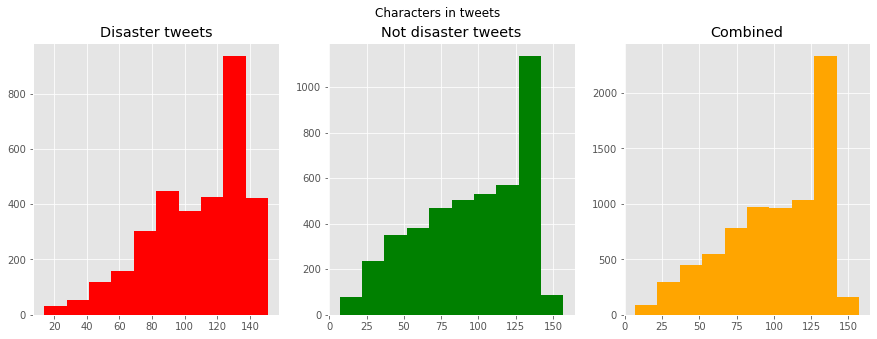

In [681]:
#comparison of number of characters for target class
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
tweet_len=tweet_train[tweet_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len=tweet_train[tweet_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
tweet_len=tweet_train['text'].str.len()
ax3.hist(tweet_len,color='orange')
ax3.set_title('Combined')
fig.suptitle('Characters in tweets')
plt.show()


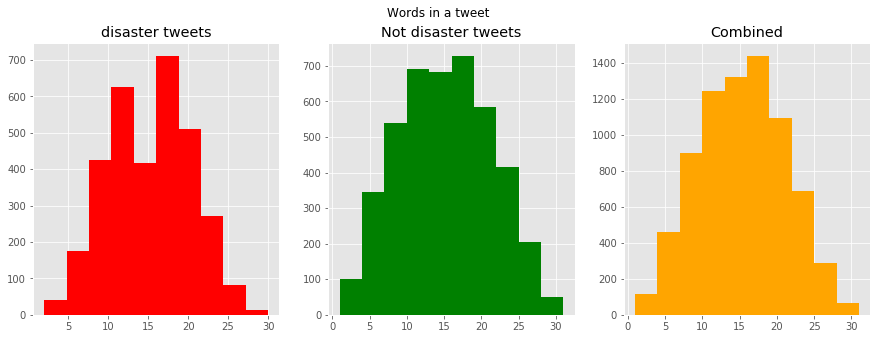

In [682]:
#comparison of number of words for target class
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
tweet_len=tweet_train[tweet_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet_train[tweet_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
tweet_len=tweet_train['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='orange')
ax3.set_title('Combined')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

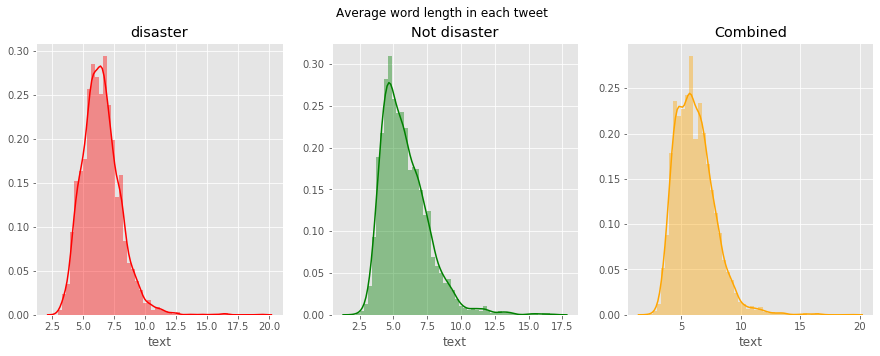

In [683]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
word=tweet_train[tweet_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet_train[tweet_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
word=tweet_train['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='orange')
ax3.set_title('Combined')
fig.suptitle('Average word length in each tweet')

#disaster tweets word length is a bit higher

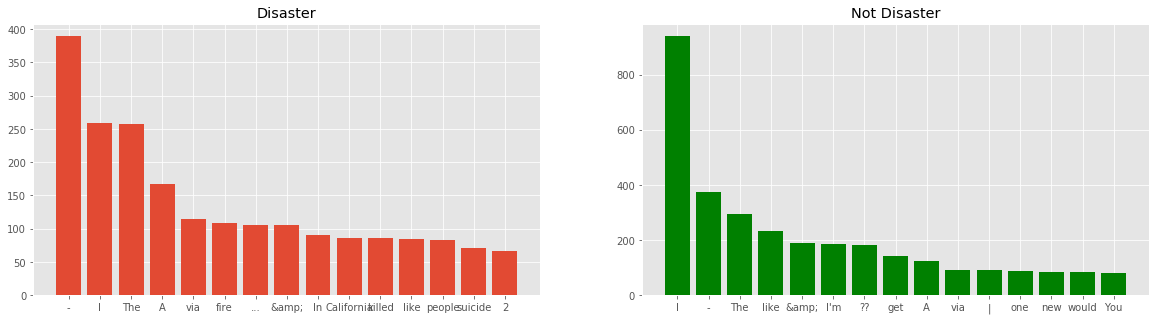

In [684]:
# word distribution in each class
def create_corpus(target):
    corpus=[]
    for x in tweet_train[tweet_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(1)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
dic=Counter([x for x in corpus if x not in stop ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
ax1.bar(x,y)
ax1.set_title('Disaster')

corpus=create_corpus(0)

dic=Counter([x for x in corpus if x not in stop ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]   
x,y=zip(*top)
ax2.bar(x,y,color='green')
ax2.set_title('Not Disaster')
plt.show()

# This text needs proper cleaning as lot of punctuation and stopwords 

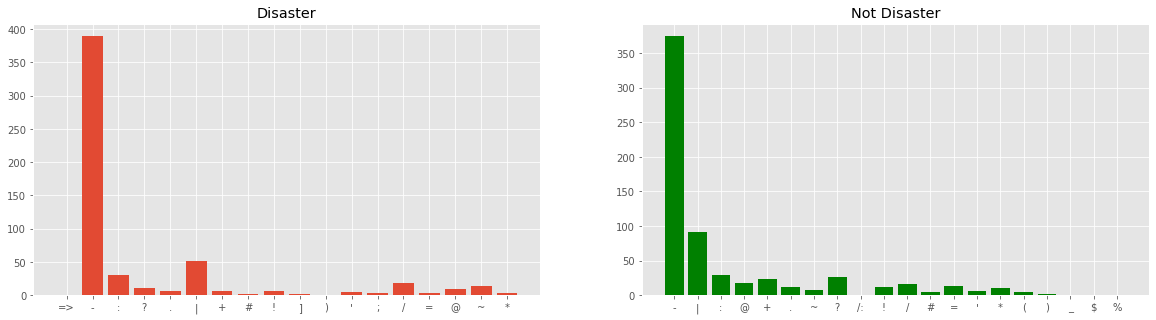

In [685]:
# Punctuation distribution in each class

corpus=create_corpus(1)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
dic=Counter([x for x in corpus if x in special])
x,y=zip(*dic.items())
ax1.bar(x,y)
ax1.set_title('Disaster')

corpus=create_corpus(0)

dic=Counter([x for x in corpus if x in special])
x,y=zip(*dic.items())
ax2.bar(x,y, color='green')
ax2.set_title('Not Disaster')
plt.show()

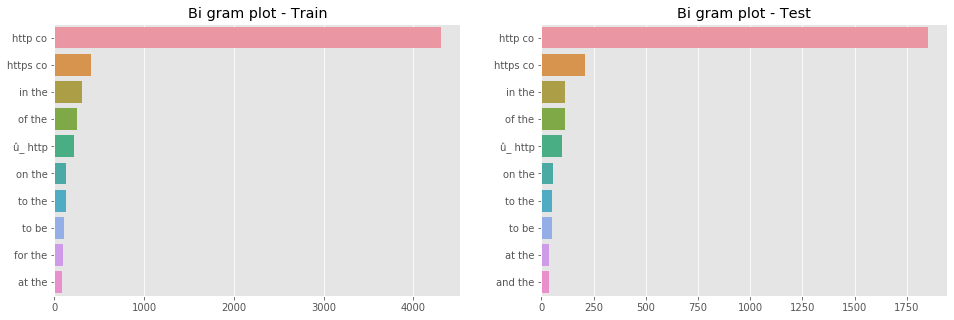

In [686]:
# Bi-gram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, ax=ax1)
ax1.set_title('Bi gram plot - Train')

top_tweet_bigrams=get_top_tweet_bigrams(tweet_test['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, ax=ax2)
ax2.set_title('Bi gram plot - Test')
plt.show()

In [687]:
# HashTag Analysis
def find_numhashtags(tweet):
    hashtag_list=re.findall(r"#(\w+)", tweet)
    return len(hashtag_list)

def find_hashtags(tweet):
    #multiple hashtags case - ?
    #hashtags in the website case
    hashtag_list=re.findall(r"#(\w+)", tweet)
    return ', '.join([x for x in hashtag_list])

def return_hashtag_keyword(tweet):
    hashtag_list=re.findall(r"#(\w+)", tweet)
    return hashtag_list[0]

tweet_train['hashtags']=tweet_train['text'].apply(lambda x: find_hashtags(x))
tweet_train['numofhashtags']=tweet_train['text'].apply(lambda x: find_numhashtags(x))

tweet_test['hashtags']=tweet_test['text'].apply(lambda x: find_hashtags(x))
tweet_test['numofhashtags']=tweet_test['text'].apply(lambda x: find_numhashtags(x))

print("Percentage of tweets having hashtags - train data")
print(round(tweet_train[tweet_train['numofhashtags']!=0].shape[0]/tweet_train.shape[0]*100,2))

print("Percentage of tweets having hashtags - test data")
print(round(tweet_test[tweet_test['numofhashtags']!=0].shape[0]/tweet_test.shape[0]*100,2))

Percentage of tweets having hashtags - train data
22.9
Percentage of tweets having hashtags - test data
24.55


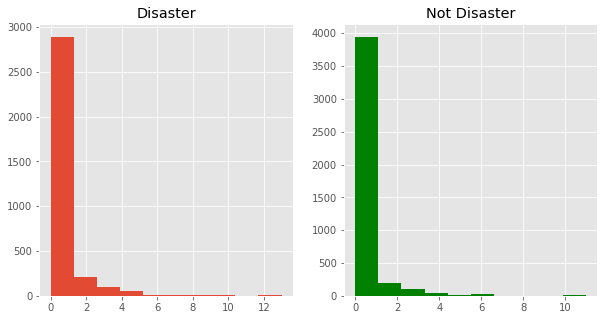

train distribution
0     0.771050
1     0.126626
2     0.053461
3     0.026534
4     0.009326
5     0.005123
6     0.003547
10    0.001314
8     0.001051
7     0.000919
13    0.000525
11    0.000263
9     0.000263
Name: numofhashtags, dtype: float64
test distribution
0     0.754520
1     0.133313
2     0.061293
3     0.027582
4     0.007662
5     0.006436
6     0.005210
7     0.001532
8     0.001226
10    0.000919
12    0.000306
Name: numofhashtags, dtype: float64


In [688]:
# num of Hashtag Distribution
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(tweet_train[tweet_train['target']==1]['numofhashtags'])
ax1.set_title('Disaster')
ax2.hist(tweet_train[tweet_train['target']==0]['numofhashtags'], color='green')
ax2.set_title('Not Disaster')
plt.show()
print('train distribution')
print(tweet_train['numofhashtags'].value_counts(normalize=True))
print('test distribution')
print(tweet_test['numofhashtags'].value_counts(normalize = True))

# single hashtags 

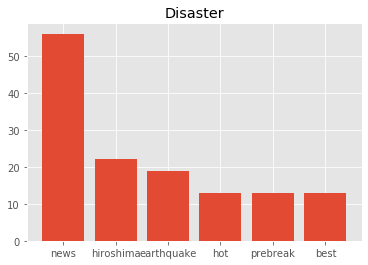

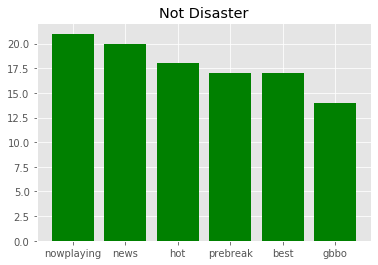

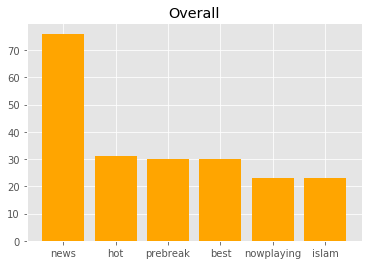

In [689]:
# Hashtag word distribution
# Target Class - 1
hashtag_corpus=[]
for x in tweet_train[tweet_train['target']==1]['hashtags'].str.split(','):
        for i in x:
            if i!='':
                hashtag_corpus.append(i.lower().strip())

dic=Counter([x for x in hashtag_corpus if x not in stop])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:6]  
x,y=zip(*top)
plt.bar(x,y)
plt.title('Disaster')
plt.show()

# Target Class - 0
hashtag_corpus=[]
for x in tweet_train[tweet_train['target']==0]['hashtags'].str.split(','):
        for i in x:
            if i!='':
                hashtag_corpus.append(i.lower().strip())

dic=Counter([x for x in hashtag_corpus if x not in stop])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:6] 
x,y=zip(*top)
plt.bar(x,y, color='Green')
plt.title('Not Disaster')
plt.show()

# Overall

hashtag_corpus=[]
for x in tweet_train['hashtags'].str.split(','):
        for i in x:
            if i!='':
                hashtag_corpus.append(i.lower().strip())

dic=Counter([x for x in hashtag_corpus if x not in stop])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:6]   
x,y=zip(*top)
plt.bar(x,y, color='Orange')
plt.title('Overall')
plt.show()

#news is a very common hashtag
# Hashtag sentiment Analysis - ?
# Based on hashtag, can create weighing feature

In [690]:
#emoji analysis
def extract_emojis(string):
    return ''.join(c for c in string if c in emoji.UNICODE_EMOJI)

tweet_train['emoji']=tweet_train['text'].apply(lambda x: extract_emojis(x))
tweet_test['emoji']=tweet_test['text'].apply(lambda x: extract_emojis(x))

# emoji sentiment Analysis - ?

In [691]:
def clean_df(df):
    def remove_stopwords(text):
        if text is not None:
            tokens = [x for x in word_tokenize(text) if x not in stop]
            return " ".join(tokens)
        else:
            return None
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)
    def remove_num(text):
        return re.sub(r'\b[0-9]+\b', '', text)
    def remove_smallwords(text):
        shortword = re.compile(r'\W*\b\w{1,3}\b')
        return shortword.sub('', text)

#     spell = SpellChecker()
#     def correct_spellings(text):
#         corrected_text = []
#         misspelled_words = spell.unknown(text.split())
#         for word in text.split():
#             if word in misspelled_words:
#                 corrected_text.append(spell.correction(word))
#             else:
#                 corrected_text.append(word)
#         return " ".join(corrected_text)
    
    df['text']=df['text'].apply(lambda x: x.lower())
    df['text']=df['text'].apply(lambda x: remove_stopwords(x))
    df['text']=df['text'].apply(lambda x: remove_URL(x))
    df['text']=df['text'].apply(lambda x: remove_html(x))
    df['text']=df['text'].apply(lambda x: remove_emoji(x))
    df['text']=df['text'].apply(lambda x: remove_punct(x))
    df['text']=df['text'].apply(lambda x: remove_num(x))
    df['text']=df['text'].apply(lambda x: remove_smallwords((x)))
    
#     df['text']=df['text'].apply(lambda x: correct_spellings(x))
    
    df.text = df.text.replace('\s+', ' ', regex=True)
    return df

tweet_train=clean_df(tweet_train)
tweet_test=clean_df(tweet_test)


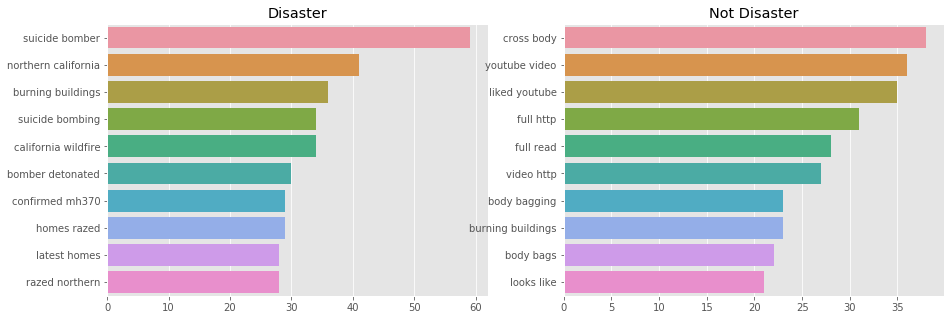

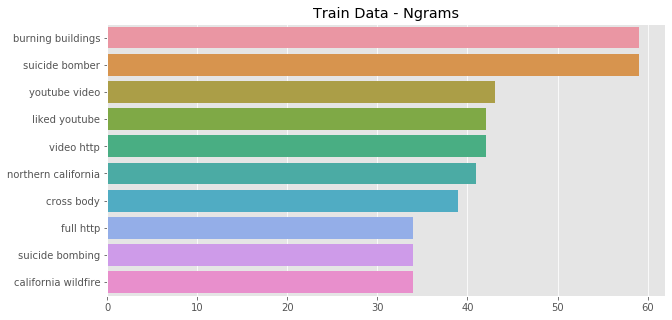

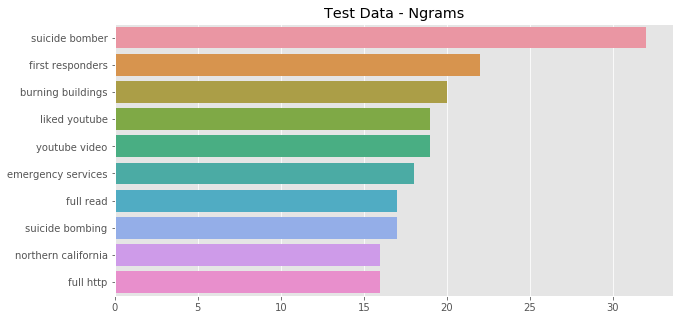

In [692]:
# Bi-gram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Bi gram Distribution for each Target Class 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet_train[tweet_train['target']==1]['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x,ax=ax1)
ax1.set_title('Disaster')
top_tweet_bigrams=get_top_tweet_bigrams(tweet_train[tweet_train['target']==0]['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x,ax=ax2)
ax2.set_title('Not Disaster')
plt.show()


plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.title('Train Data - Ngrams')
plt.show()


plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet_test['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.title('Test Data - Ngrams')
plt.show()


# Video and video links are good reference 
# Analysing the links can help in making new features
# Lot of Links in not disaster class
# Bi-grams seems to be a good classifier 

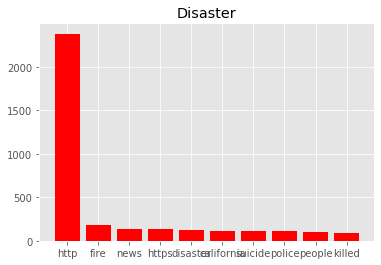

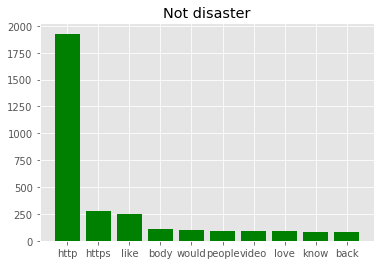

In [693]:
# word distribution in each class
corpus=create_corpus(1)

dic=Counter([x for x in corpus if x not in stop])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]   
x,y=zip(*top)
plt.bar(x,y, color='red')
plt.title('Disaster')
plt.show()

corpus=create_corpus(0)

dic=Counter([x for x in corpus if x not in stop])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y,color='green')
plt.title('Not disaster')
plt.show()


In [694]:
# Number of Links in a tweet
tweet_train['numoflinks']=tweet_train['text'].apply(lambda x: len(re.findall(r"http(\w+)", x)))
tweet_test['numoflinks']=tweet_test['text'].apply(lambda x: len(re.findall(r"http(\w+)", x)))

In [695]:
# Removing http due to low discriminative power
tweet_train['text']=tweet_train['text'].apply(lambda x: x.replace('http', ''))
tweet_train['text']=tweet_train['text'].apply(lambda x: x.replace('https', ''))
tweet_train['text']=tweet_train['text'].apply(lambda x: x.replace('\s+', ' '))


tweet_test['text']=tweet_test['text'].apply(lambda x: x.replace('http', ''))
tweet_test['text']=tweet_test['text'].apply(lambda x: x.replace('https', ''))
tweet_test['text']=tweet_test['text'].apply(lambda x: x.replace('\s+', ' '))

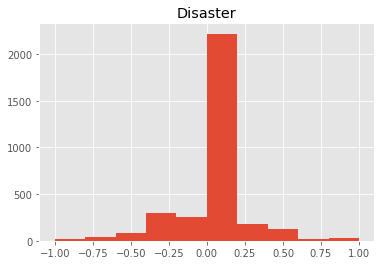

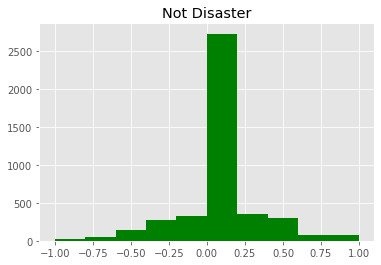

In [696]:
# sentiment of tweet
def polarity(strings):
    sent=TextBlob(strings).sentiment
    return sent.polarity

tweet_train['sentiment']=tweet_train['text'].apply(lambda x: polarity(x))
tweet_test['sentiment']=tweet_test['text'].apply(lambda x: polarity(x))

#frequency distribution of sentiment

plt.hist(tweet_train[tweet_train['target']==1]['sentiment'])
plt.title('Disaster')
plt.show()


plt.hist(tweet_train[tweet_train['target']==0]['sentiment'],color='green')
plt.title('Not Disaster')
plt.show()

# sentiments are quite similar for both class
# Sentiments cannot be a good classifier

## Word Clouds

Train Words Cloud


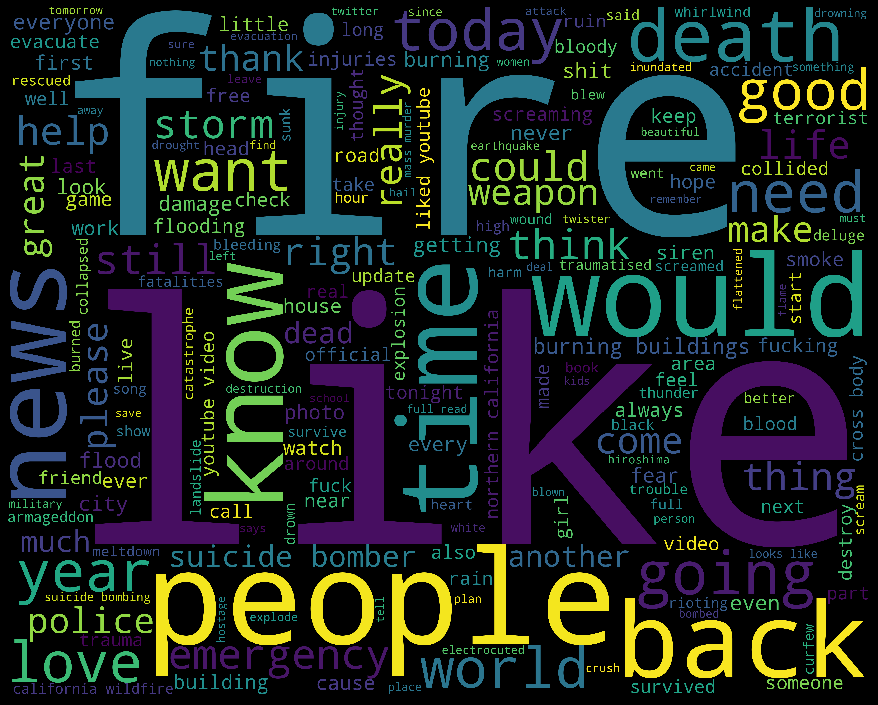

Test Words Cloud


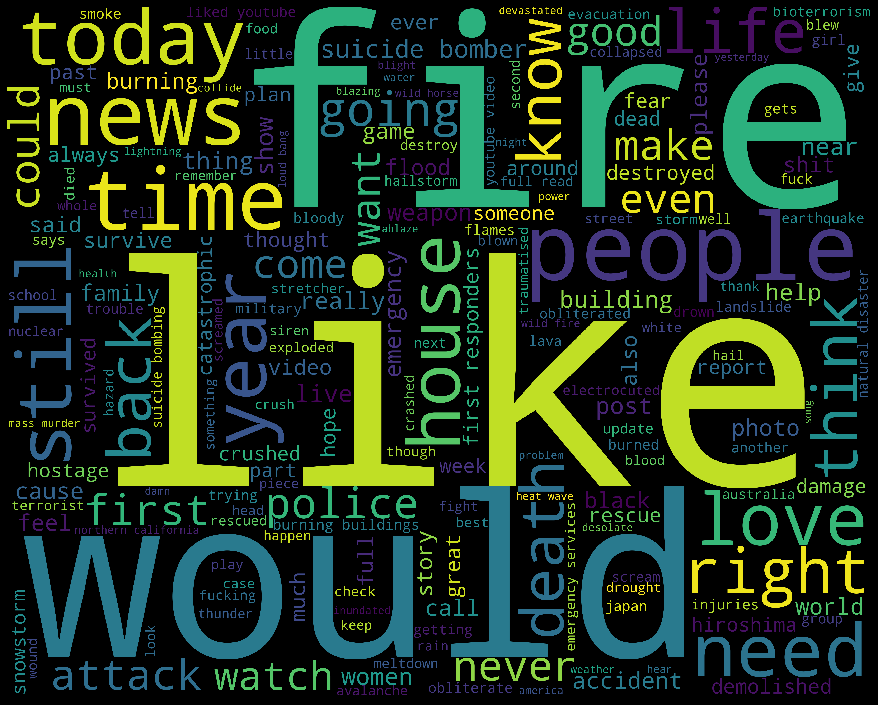

Disaster Tweets Words Cloud


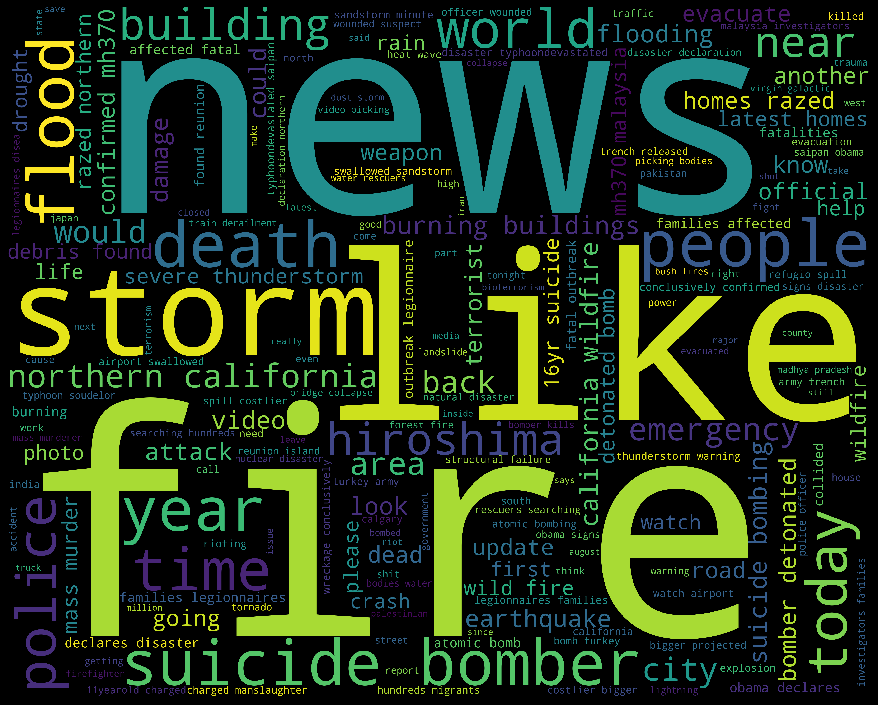

Not Disaster Tweets Words Cloud


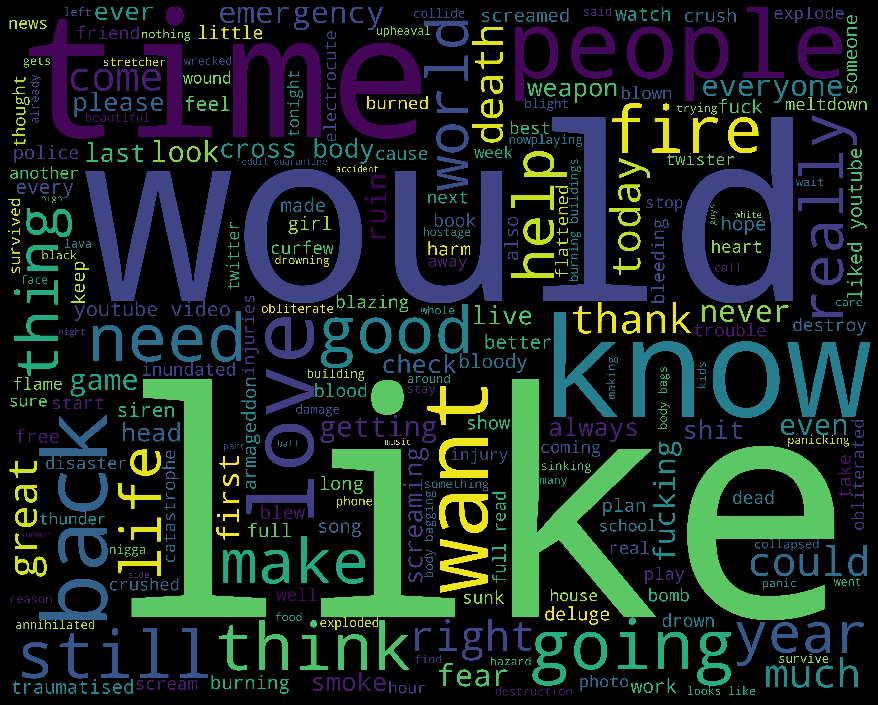

In [697]:
# train word cloud
def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(stop) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
print('Train Words Cloud') 
text = tweet_train.text.values
Plot_world(text)

print('Test Words Cloud') 
text = tweet_test.text.values
Plot_world(text)

print('Disaster Tweets Words Cloud') 
text = tweet_train[tweet_train['target']==1].text.values
Plot_world(text)

print('Not Disaster Tweets Words Cloud') 
text = tweet_train[tweet_train['target']==0].text.values
Plot_world(text)



## Keyword Analysis

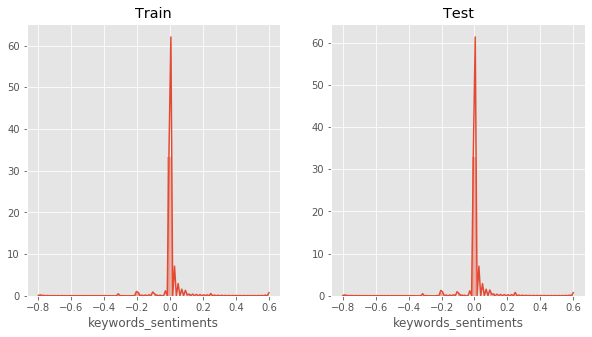

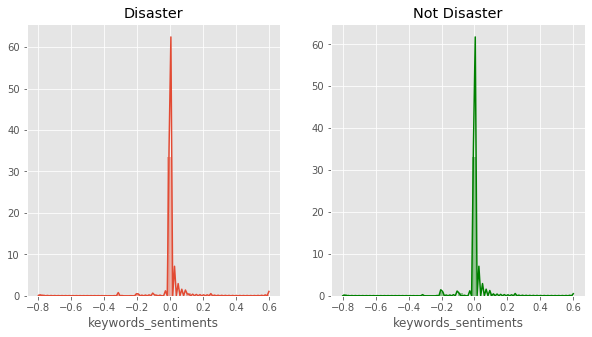

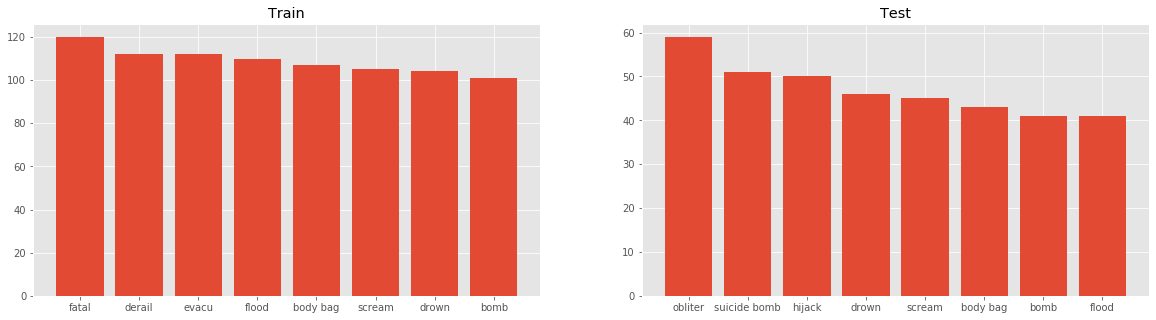

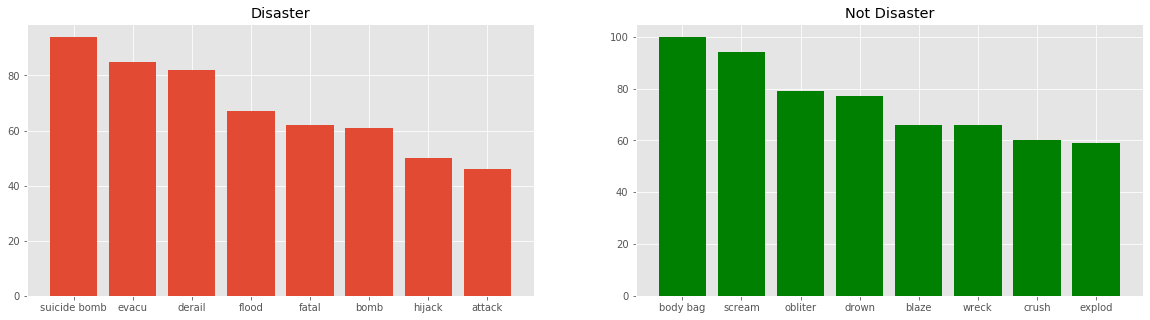

Train Stats
Number of Unique keywords before stemming : -
237
Number of Unique keywords after stemming : -
181
Test Stats
Number of Unique keywords before stemming : -
226
Number of Unique keywords after stemming : -
170


In [698]:
#Removing encoded space character 
tweet_train['keyword']=tweet_train['keyword'].map(lambda s: s.replace('%20', ' ') if isinstance(s, str) else s)
tweet_test['keyword']=tweet_test['keyword'].map(lambda s: s.replace('%20', ' ') if isinstance(s, str) else s)


#filling NAs with hashtags
tweet_train['keyword'].fillna(tweet_train['hashtags'].apply(lambda x: np.NaN if x=='' else x.split(',')[-1].strip()), inplace=True)
tweet_test['keyword'].fillna(tweet_test['hashtags'].apply(lambda x: np.NaN if x=='' else x.split(',')[-1].strip()), inplace=True)



# fill remaining with neutral word
tweet_train['keyword'].fillna('the',inplace=True)
tweet_train['keyword']=tweet_train['keyword'].apply(lambda x: str(x).lower())
tweet_test['keyword'].fillna('the',inplace=True)
tweet_test['keyword']=tweet_test['keyword'].apply(lambda x: str(x).lower())

#polarity of keywords
tweet_train['keywords_sentiments']=tweet_train['keyword'].apply(lambda x: polarity(x))
tweet_test['keywords_sentiments']=tweet_test['keyword'].apply(lambda x: polarity(x))

# polarity distribution - overall, train, test, disaster, not disaster
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(tweet_train['keywords_sentiments'],ax=ax1)
ax1.set_title('Train')
sns.distplot(tweet_test['keywords_sentiments'],ax=ax2)
ax2.set_title('Test')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(tweet_train[tweet_train['target']==1]['keywords_sentiments'],ax=ax1)
ax1.set_title('Disaster')
sns.distplot(tweet_train[tweet_train['target']==0]['keywords_sentiments'],color='green',ax=ax2)
ax2.set_title('Not Disaster')
plt.show()

#stemming is required as lot of keywords are related
ps = PorterStemmer()
tweet_train['stem_key']=tweet_train['keyword'].apply(lambda x: ps.stem(x.strip()))
tweet_test['stem_key']=tweet_test['keyword'].apply(lambda x: ps.stem(x.strip()))

#word distribution - train - disaster:not disaster, test
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
dic=Counter([x for x in tweet_train['stem_key'].tolist() if x not in word ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:8] 
x,y=zip(*top)
ax1.bar(x,y)
ax1.set_title('Train')
dic=Counter([x for x in tweet_test['stem_key'].tolist() if x not in word ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:8] 
x,y=zip(*top)
ax2.bar(x,y)
ax2.set_title('Test')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
dic=Counter([x for x in tweet_train[tweet_train['target']==1]['stem_key'].tolist() if x not in word ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:8] 
x,y=zip(*top)
ax1.bar(x,y)
ax1.set_title('Disaster')
dic=Counter([x for x in tweet_train[tweet_train['target']==0]['stem_key'].tolist() if x not in word ])
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:8] 
x,y=zip(*top)
ax2.bar(x,y,color='green')
ax2.set_title('Not Disaster')
plt.show()

#How stemming helped?
print("Train Stats")
print("Number of Unique keywords before stemming : -")
print(len(set(tweet_train['keyword'].tolist())))
print("Number of Unique keywords after stemming : -")
print(len(set(tweet_train['stem_key'].tolist())))

print("Test Stats")
print("Number of Unique keywords before stemming : -")
print(len(set(tweet_test['keyword'].tolist())))
print("Number of Unique keywords after stemming : -")
print(len(set(tweet_test['stem_key'].tolist())))

#good difference in keywords for the target class

In [699]:
disaster_keywords = tweet_train[tweet_train['target']==1]['stem_key'].tolist()
regular_keywords = tweet_train[tweet_train['target']==0]['stem_key'].tolist()
disaster_keywords_counts = dict(pd.DataFrame(data={'x': disaster_keywords}).x.value_counts())
regular_keywords_counts = dict(pd.DataFrame(data={'x': regular_keywords}).x.value_counts())
# we sort the keywords so the most frequents are on top and we print them with relative
# occurrences in both classes of tweets:

for keyword, _ in sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("> KW: {}".format(keyword))
    print("-- # in class 1: {}".format(disaster_keywords_counts.get(keyword, 0)))
    print("-- # in class 0: {}".format(regular_keywords_counts.get(keyword, 0)))
    print('--------')

"""for each keyword, a new feature can be created using the occurence in both classes and 
based on that we can create a indicator word feature"""

> KW: body bag
-- # in class 1: 7
-- # in class 0: 100
--------
> KW: scream
-- # in class 1: 11
-- # in class 0: 94
--------
> KW: obliter
-- # in class 1: 12
-- # in class 0: 79
--------
> KW: drown
-- # in class 1: 27
-- # in class 0: 77
--------
> KW: blaze
-- # in class 1: 6
-- # in class 0: 66
--------
> KW: wreck
-- # in class 1: 10
-- # in class 0: 66
--------
> KW: crush
-- # in class 1: 8
-- # in class 0: 60
--------
> KW: explod
-- # in class 1: 12
-- # in class 0: 59
--------
> KW: fatal
-- # in class 1: 62
-- # in class 0: 58
--------
> KW: siren
-- # in class 1: 12
-- # in class 0: 57
--------


'for each keyword, a new feature can be created using the occurence in both classes and \nbased on that we can create a indicator word feature'

## Location Analysis 

In [700]:
print("total null values :",tweet_train['location'].isnull().sum())
#Sparse 
tweet_train['location'].value_counts()

# check if location column is really a location -?
# fill NAs by extracting location from text -?

total null values : 2533


USA                             104
New York                         71
United States                    50
London                           45
Canada                           29
                               ... 
(a) property of the universe      1
Near Yosemite                     1
  Melbourne, Australia            1
ona block w/ my BOY ??            1
under the blanket                 1
Name: location, Length: 3341, dtype: int64

## Clustering of words on Pre Trained Models

In [701]:
#creating a word vocab from all the data we hae
vocab_list=[item for sublist in tweet_train['text'].apply(lambda x: x.split()).tolist() for item in sublist] +\
[item for sublist in tweet_train['keyword'].apply(lambda x: x.split()).tolist() for item in sublist] +\
[item for sublist in tweet_train['hashtags'].apply(lambda x: x.split(',')).tolist() for item in sublist]

In [702]:
#getting pre trained Glove Vectors - run only once
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

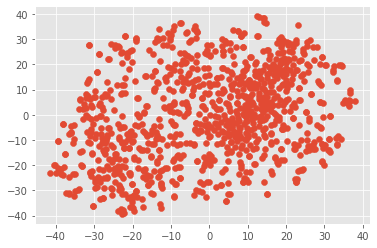

In [703]:

tsne = TSNE(n_components=2, random_state=45)
vectors=[]
for word in unique_vocab_list:
    try:
        vectors.append(embeddings_dict[word])
    except:
        continue
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()
# there are two cluster words and can be used to create a feature - if it belongs to important cluster mark it as 1

## Vectorization and LogReg

In [704]:
# tfidf 
vectorizer = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,3))
train_vector = vectorizer.fit_transform(tweet_train['text'])
test_vector = vectorizer.transform(tweet_test['text'])
train_df=pd.DataFrame(train_vector.toarray(),columns = vectorizer.get_feature_names())
test_df=pd.DataFrame(test_vector.toarray(),columns = vectorizer.get_feature_names())
train_df['target']=tweet_train['target']

In [705]:
#logreg
logreg=LogisticRegression(verbose=1,random_state=0, C=5, penalty='l2')
model=logreg.fit(train_df.loc[:,train_df.columns!='target'],train_df['target'])
print("train accuracy")
train_pred=model.predict(train_df.loc[:,train_df.columns!='target'])
print(accuracy_score(train_df['target'], train_pred))

[LibLinear]train accuracy
0.7221857349270984


/Users/rks/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [706]:
#test_submission
test_pred=model.predict(test_df)
submission=pd.read_csv('sample_submission.csv')
submission['target']=test_pred
submission.to_csv('sub1log.csv',index=False)

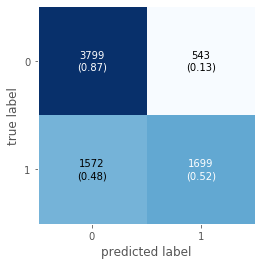

In [707]:
#train confusion metrics
cm=confusion_matrix(train_df['target'], train_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True)
plt.show()

## New features and logreg

In [708]:
"""
feature 1 - word length
feature 2 - number of links
feature 3 - keyword weight
"""

# feature 1 - word length
tweet_train['avg_word_len']=tweet_train['text'].apply(lambda x: np.average([len(i) for i in x.split()]))
tweet_test['avg_word_len']=tweet_test['text'].apply(lambda x: np.average([len(i) for i in x.split()]))
tweet_train['avg_word_len'].fillna(0,inplace=True)
tweet_test['avg_word_len'].fillna(0,inplace=True)

# feature 2 - number of links - already done

# feature 3 - keyword weight - should be normalized #
def keyword_weight(kw,df):
    freq1class=df[(df['stem_key']==kw)&(df['target']==1)].shape[0]
    freq0class=df[(df['stem_key']==kw)&(df['target']==0)].shape[0]
    if freq0class==0:
        return freq1class
    else:
        return freq1class/freq0class
tweet_train['keyword_weight']=tweet_train['stem_key'].apply(lambda x: keyword_weight(x,tweet_train))
kw_dict=pd.Series(tweet_train.keyword_weight.values,index=tweet_train.stem_key).to_dict()
tweet_test['keyword_weight']=tweet_test['stem_key'].apply(lambda x: kw_dict[x] if x in list(kw_dict.keys()) else 0)

/Users/rks/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


In [709]:
#logreg
columns = ['keyword_weight', 'avg_word_len', 'numoflinks']
train_df=tweet_train[columns]
test_df=tweet_test[columns]
logreg=LogisticRegression(verbose=1,random_state=0, C=5, penalty='l2')
model=logreg.fit(train_df,tweet_train['target'])
print("train accuracy")
train_pred=model.predict(train_df)
print(accuracy_score(tweet_train['target'], train_pred))

[LibLinear]train accuracy
0.7162747931170367


/Users/rks/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [710]:
#test_submission
test_pred=model.predict(test_df)
submission=pd.read_csv('sample_submission.csv')
submission['target']=test_pred
submission.to_csv('sub2log.csv',index=False)

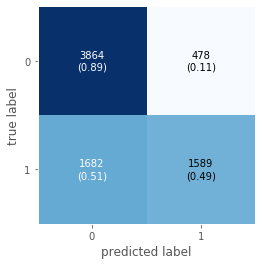

In [711]:
#train confusion metrics
cm=confusion_matrix(tweet_train['target'], train_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True)
plt.show()

In [712]:
"""
1. Creating a hashtag feature
2. Exploring the word clusters
3. Using N grams along with new features
4. including the locations as well
5. advanced predictive models
6. using pre trained vectors to create sentence vector for training
7. feature importance and re-iterate
"""

'\n1. Creating a hashtag feature\n2. Exploring the word clusters\n3. Using N grams along with new features\n4. including the locations as well\n5. advanced predictive models\n6. using pre trained vectors to create sentence vector for training\n7. feature importance and re-iterate\n'